In [2]:
import numpy as np
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import KFold, train_test_split
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# Load the MNIST dataset
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

# Convert the string labels to integers
le = LabelEncoder()
y = le.fit_transform(y)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define the activation functions and their derivatives
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))

def softmax(x):
    exps = np.exp(x - np.max(x, axis=0, keepdims=True))
    return exps / (np.sum(exps, axis=0, keepdims=True))

def softmax_derivative(x):
    p = softmax(x)
    return p * (1 - p)

def hidden_activation(x, k0, k1):
    return k0 + k1 * x

def hidden_activation_derivative(x, k0, k1):
    return k1

n_i = X_train.shape[1]  # Number of inputs
n_o = len(np.unique(y))  # Number of outputs

avg_train_f1_scores = []

learning_rate = 0.21

hidden_layer_sizes = [790, 1024, 4000]
kf = KFold(n_splits=3)

# Initialize the best scores and the corresponding number of hidden nodes
best_train_f1 = -np.inf
best_train_accuracy = -np.inf
best_test_f1 = -np.inf
best_test_accuracy = -np.inf
best_n_h = None

# Initialize lists to store the training loss and F1-score for each epoch
train_losses = []
train_f1_scores = []

# Iterate over the different numbers of nodes in the hidden layer
for n_h in hidden_layer_sizes:
    f1_scores = []
    train_accuracies = []
    test_accuracies = []

    for train_index, val_index in kf.split(X_train):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        k0 = np.random.randn()
        k1 = np.random.randn()

        np.random.seed(42)
        W1 = np.random.randn(n_h, n_i)
        b1 = np.zeros(n_h)
        W2 = np.random.randn(n_o, n_h)
        b2 = np.zeros(n_o)

        for epoch in range(100):
            Z1 = np.dot(W1, X_train_fold.T) + b1[:, None]
            A1 = hidden_activation(Z1, k0, k1)
            Z2 = np.dot(W2, A1) + b2[:, None]
            A2 = softmax(Z2)

            epsilon = 1e-7  # small constant
            A2_clipped = np.clip(A2, epsilon, 1 - epsilon)  # avoid extreme values
            loss = -np.mean(y_train_fold * np.log(A2_clipped))
            train_losses.append(loss)  # Store the training loss for this epoch

            predictions_train = np.argmax(A2, axis=0)
            f1 = f1_score(y_train_fold, predictions_train, average="macro")
            train_f1_scores.append(f1)  # Store the training F1-score for this epoch

            dZ2 = A2 - y_train_fold[None, :]
            dW2 = np.dot(dZ2, A1.T) / X_train_fold.shape[0]
            db2 = np.sum(dZ2, axis=1) / X_train_fold.shape[0]
            dZ1 = np.dot(W2.T, dZ2) * hidden_activation_derivative(Z1, k0, k1)
            dW1 = np.dot(dZ1, X_train_fold) / X_train_fold.shape[0]
            db1 = np.sum(dZ1, axis=1) / X_train_fold.shape[0]

            W1 -= learning_rate * dW1
            b1 -= learning_rate * db1
            W2 -= learning_rate * dW2
            b2 -= learning_rate * db2

        Z1 = np.dot(W1, X_val_fold.T) + b1[:, None]
        A1 = hidden_activation(Z1, k0, k1)
        Z2 = np.dot(W2, A1) + b2[:, None]
        A2 = softmax(Z2)
        predictions_val = np.argmax(A2, axis=0)

        f1_val = f1_score(y_val_fold, predictions_val, average="macro")
        accuracy_val = accuracy_score(y_val_fold, predictions_val)

        accuracy_train = accuracy_score(y_train_fold, predictions_train)

        f1_scores.append(f1_val)
        train_accuracies.append(accuracy_train)
        test_accuracies.append(accuracy_val)

    avg_train_f1 = np.mean(f1_scores)
    avg_train_accuracy = np.mean(train_accuracies)
    avg_test_f1 = np.mean(f1_scores)
    avg_test_accuracy = np.mean(test_accuracies)

    avg_train_f1_scores.append(avg_train_f1)

    if avg_test_f1 > best_test_f1:
        best_train_f1 = avg_train_f1
        best_train_accuracy = avg_train_accuracy
        best_test_f1 = avg_test_f1
        best_test_accuracy = avg_test_accuracy
        best_n_h = n_h
        best_model = (W1, b1, W2, b2, k0, k1)  # Store the parameters of the best model

    print(f"\nNumber of nodes: {n_h}")
    print(f"Train F1-score: {avg_train_f1}")
    print(f"Train Accuracy: {avg_train_accuracy}")
    print(f"Validation F1-score: {avg_test_f1}")
    print(f"Validation Accuracy: {avg_test_accuracy}")

# Print the scores for the best model
print("\nBest model:")
print(f"Number of nodes: {best_n_h}")
print(f"Best Train F1-score: {best_train_f1}")
print(f"Best Train Accuracy: {best_train_accuracy}")
print(f"Best Test F1-score: {best_test_f1}")
print(f"Best Test Accuracy: {best_test_accuracy}")


/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(



Number of nodes: 790
Train F1-score: 0.01801314933244153
Train Accuracy: 0.13836606013058014
Validation F1-score: 0.01801314933244153
Validation Accuracy: 0.05080357688198742

Number of nodes: 1024
Train F1-score: 0.010267791598400022
Train Accuracy: 0.16980358731966097
Validation F1-score: 0.010267791598400022
Validation Accuracy: 0.03244641264795954

Number of nodes: 4000
Train F1-score: 0.024003561052894404
Train Accuracy: 0.1252946389709044
Validation F1-score: 0.024003561052894404
Validation Accuracy: 0.0758214493471959

Best model:
Number of nodes: 4000
Best Train F1-score: 0.024003561052894404
Best Train Accuracy: 0.1252946389709044
Best Test F1-score: 0.024003561052894404
Best Test Accuracy: 0.0758214493471959


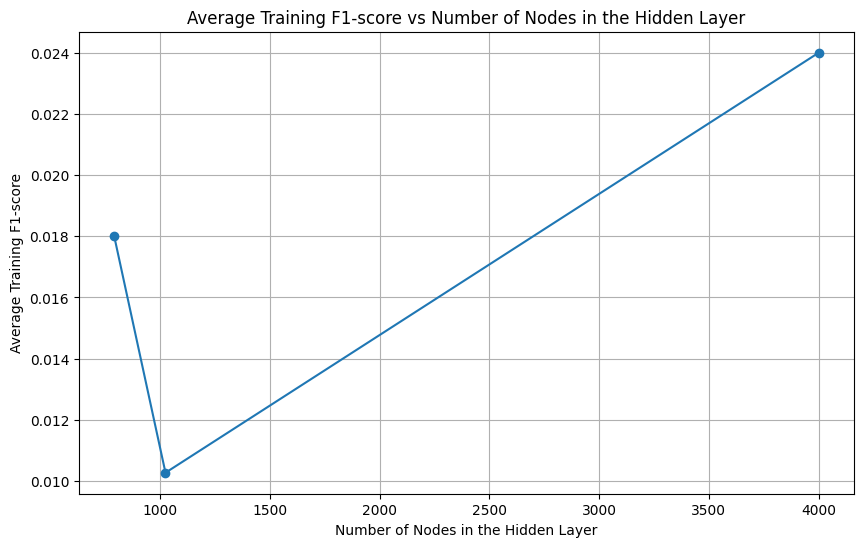

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(hidden_layer_sizes, avg_train_f1_scores, marker='o')
plt.title('Average Training F1-score vs Number of Nodes in the Hidden Layer')
plt.xlabel('Number of Nodes in the Hidden Layer')
plt.ylabel('Average Training F1-score')
plt.grid(True)
plt.show()


Best model:
Number of nodes: 4000
Train F1-score: 0.024003561052894404
Train Accuracy: 0.1252946389709044
Test F1-score: 0.02364063317125106
Test Accuracy: 0.07507142857142857


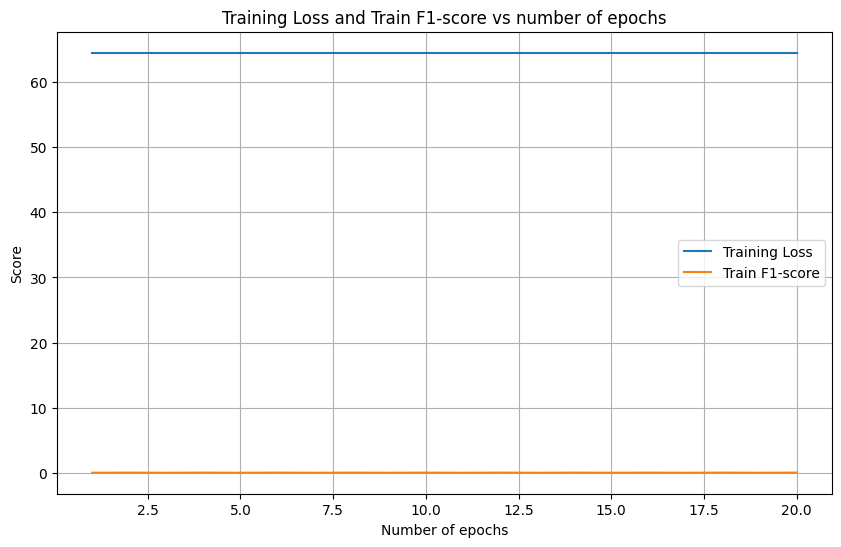

In [5]:
import matplotlib.pyplot as plt

# Initialize lists to store the training loss and F1-score for each epoch
train_losses = []
train_f1_scores = []

# Retrieve the parameters of the best model
W1, b1, W2, b2, k0, k1 = best_model

for epoch in range(20):
    Z1 = np.dot(W1, X_train.T) + b1[:, None]
    A1 = hidden_activation(Z1, k0, k1)
    Z2 = np.dot(W2, A1) + b2[:, None]
    A2 = softmax(Z2)

    epsilon = 1e-7  # small constant
    A2_clipped = np.clip(A2, epsilon, 1 - epsilon)  # avoid extreme values
    loss = -np.mean(y_train * np.log(A2_clipped))
    train_losses.append(loss)  # Store the training loss for this epoch

    predictions_train = np.argmax(A2, axis=0)
    f1 = f1_score(y_train, predictions_train, average="macro")
    train_f1_scores.append(f1)  # Store the training F1-score for this epoch

    dZ2 = A2 - y_train[None, :]
    dW2 = np.dot(dZ2, A1.T) / X_train.shape[0]
    db2 = np.sum(dZ2, axis=1) / X_train.shape[0]
    dZ1 = np.dot(W2.T, dZ2) * hidden_activation_derivative(Z1, k0, k1)
    dW1 = np.dot(dZ1, X_train) / X_train.shape[0]
    db1 = np.sum(dZ1, axis=1) / X_train.shape[0]

    W1 -= learning_rate * dW1
    b1 -= learning_rate * db1
    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2

# Test the model on the test data
Z1 = np.dot(W1, X_test.T) + b1[:, None]
A1 = hidden_activation(Z1, k0, k1)
Z2 = np.dot(W2, A1) + b2[:, None]
A2 = softmax(Z2)
predictions_test = np.argmax(A2, axis=0)

f1_test = f1_score(y_test, predictions_test, average="macro")
accuracy_test = accuracy_score(y_test, predictions_test)

print("\nBest model:")
print(f"Number of nodes: {best_n_h}")
print(f"Train F1-score: {best_train_f1}")
print(f"Train Accuracy: {best_train_accuracy}")
print(f"Test F1-score: {f1_test}")
print(f"Test Accuracy: {accuracy_test}")

# Plot the training loss and F1-score for each epoch
plt.figure(figsize=(10, 6))
plt.plot(range(1, 21), train_losses, label='Training Loss')
plt.plot(range(1, 21), train_f1_scores, label='Train F1-score')
plt.title('Training Loss and Train F1-score vs number of epochs')
plt.xlabel('Number of epochs')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()
